In [19]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
# import umap
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance

In [20]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [21]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [22]:
decoder_beta = keras.models.load_model("models/level5Decoder_beta")
encoder_beta = keras.models.load_model("models/level5Encoder_beta")
decoder_vanilla = keras.models.load_model("models/level5Decoder_vanilla")
encoder_vanilla = keras.models.load_model("models/level5Encoder_vanilla")
decoder_mmd = keras.models.load_model("models/level5Decoder_mmd")
encoder_mmd = keras.models.load_model("models/level5Encoder_mmd")

decoder_beta_shuffled = keras.models.load_model("models/level5DecoderShuffled_beta")
encoder_beta_shuffled = keras.models.load_model("models/level5EncoderShuffled_beta")
decoder_vanilla_shuffled = keras.models.load_model("models/level5DecoderShuffled_vanilla")
encoder_vanilla_shuffled = keras.models.load_model("models/level5EncoderShuffled_vanilla")
decoder_mmd_shuffled = keras.models.load_model("models/level5DecoderShuffled_mmd")
encoder_mmd_shuffled = keras.models.load_model("models/level5EncoderShuffled_mmd")


In [23]:
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

shuffled_df = shuffle_each_column(train_features_df)

In [24]:
pca = PCA(n_components=10).fit(train_features_df)
pca_shuffled = PCA(n_components=10).fit(shuffled_df)

In [25]:
test_features_df

,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.744130,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.124990,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.192490,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058
3,0.39758,0.58312,0.28160,0.58321,0.65768,0.20819,0.52003,0.76726,0.76558,0.77228,...,0.222870,0.36290,0.34899,0.36145,0.65591,0.58757,0.57525,0.40197,0.42430,0.40650
4,0.62913,0.58137,0.63998,0.52072,0.55315,0.26703,0.45668,0.89299,0.66578,0.66670,...,0.148800,0.22266,0.19739,0.22568,0.56938,0.46103,0.43544,0.32082,0.36858,0.34326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0.57958,0.58341,0.60465,0.49947,0.61174,0.32603,0.49462,0.78942,0.65961,0.69082,...,0.144570,0.23583,0.21537,0.23648,0.59933,0.49197,0.41249,0.34833,0.39164,0.36789
1033,0.58973,0.57850,0.63496,0.53818,0.56796,0.27108,0.51437,0.88819,0.68937,0.64571,...,0.112840,0.17094,0.15515,0.16859,0.57132,0.46935,0.42794,0.32039,0.37061,0.34539
1034,0.46436,0.58285,0.58208,0.49729,0.54188,0.33614,0.55652,0.72208,0.65734,0.79649,...,0.352030,0.38901,0.36684,0.41414,0.62192,0.53495,0.49820,0.38631,0.42841,0.40471
1035,0.55502,0.54386,0.61972,0.48276,0.58335,0.32330,0.48132,0.81005,0.62664,0.69773,...,0.221320,0.28805,0.26998,0.28763,0.59025,0.49317,0.46200,0.32372,0.35525,0.33277


In [26]:
reconstruction_beta = pd.DataFrame(decoder_beta.predict(encoder_beta.predict(test_features_df)[2]))
# reconstruction_beta['label'] = 'β-VAE reconstruction'
reconstruction_vanilla = pd.DataFrame(decoder_vanilla.predict(encoder_vanilla.predict(test_features_df)[2]))
# reconstruction_vanilla['label'] = 'Vanilla VAE reconstruction'
reconstruction_mmd = pd.DataFrame(decoder_mmd.predict(encoder_mmd.predict(test_features_df)[2]))
# reconstruction_mmd['label'] = 'MMD-VAE reconstruction'
reconstruction_pca = pd.DataFrame(pca.inverse_transform(pca.transform(test_features_df)))

reconstruction_beta_shuffled = pd.DataFrame(decoder_beta_shuffled.predict(encoder_beta_shuffled.predict(test_features_df)[2]))
reconstruction_vanilla_shuffled = pd.DataFrame(decoder_vanilla_shuffled.predict(encoder_vanilla_shuffled.predict(test_features_df)[2]))
reconstruction_mmd_shuffled = pd.DataFrame(decoder_mmd_shuffled.predict(encoder_mmd_shuffled.predict(test_features_df)[2]))
reconstruction_pca_shuffled = pd.DataFrame(pca_shuffled.inverse_transform(pca.transform(test_features_df)))


In [33]:
df = pd.DataFrame()
reconstructions = [reconstruction_vanilla, reconstruction_beta, reconstruction_mmd, reconstruction_pca]
reconstructions_shuffled = [reconstruction_vanilla_shuffled, reconstruction_beta_shuffled, reconstruction_mmd_shuffled, reconstruction_pca_shuffled]
model_names = ['Vanilla', 'Beta', 'MMD', 'PCA']

for i in range(len(reconstructions)):
    mse = mean_squared_error(reconstructions[i], test_features_df)
    mse_shuffled = mean_squared_error(reconstructions_shuffled[i], test_features_df)
    
    combined_df = pd.concat([reconstructions[i], test_features_df], axis = 1)
    combined_df.columns = np.arange(1176)
    distance = combined_df.apply(lambda row : wasserstein_distance(row[np.arange(0,588)], row[np.arange(588,1175)]), axis = 1)
    
    combined_df_shuffled = pd.concat([reconstructions_shuffled[i], test_features_df], axis = 1)
    combined_df_shuffled.columns = np.arange(1176)
    distance_shuffled = combined_df_shuffled.apply(lambda row : wasserstein_distance(row[np.arange(0,588)], row[np.arange(588,1175)]), axis = 1)
    row = pd.DataFrame({'Dataset': ['Cell Painting level 5'], 'VAE': [model_names[i]], 'MSE': [mse], 'MSE (Shuffled)': [mse_shuffled], 'Earthmoving': [distance.mean()], 'Earthmoving (Shuffled)': [distance_shuffled.mean()], 'Earthmoving 5%': [np.sort(distance)[52]], 'Earthmoving 95%': [np.sort(distance)[984]], 'Earthmoving (Shuffled) 5%': [np.sort(distance_shuffled)[52]], 'Earthmoving (Shuffled) 95%': [np.sort(distance_shuffled)[984]]})
    df = pd.concat([df, row])
    
df = df.reset_index(drop = True)

    

In [36]:
df.to_csv('cp5_reconstruction_metrics.csv', index = False)

In [6]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(1037, 10)), columns=np.arange(0,10))
reconstruction_of_simulated_test_beta = pd.DataFrame(decoder_beta.predict(simulated_test_df))
reconstruction_of_simulated_test_beta['label'] = 'β-VAE simulation'
reconstruction_of_simulated_test_vanilla = pd.DataFrame(decoder_vanilla.predict(simulated_test_df))
reconstruction_of_simulated_test_vanilla['label'] = 'Vanilla VAE simulation'

reconstruction_of_simulated_test_mmd = pd.DataFrame(decoder_mmd.predict(simulated_test_df))
reconstruction_of_simulated_test_mmd['label'] = 'MMD-VAE simulation'
test_features_df.columns = np.arange(0,588)
test_features_df['label'] = 'Original'

In [7]:
beta_df = pd.concat([test_features_df, reconstruction_beta,reconstruction_of_simulated_test_beta])
mmd_df = pd.concat([test_features_df,reconstruction_mmd,reconstruction_of_simulated_test_mmd])
vanilla_df = pd.concat([test_features_df,reconstruction_vanilla,reconstruction_of_simulated_test_vanilla])

labels_beta = beta_df.label.reset_index(drop=True)
labels_mmd = mmd_df.label.reset_index(drop=True)
labels_vanilla = vanilla_df.label.reset_index(drop=True)

beta_df = beta_df.drop('label', axis = 1)
mmd_df = mmd_df.drop('label', axis = 1)
vanilla_df = vanilla_df.drop('label', axis = 1)

In [55]:
reducer = umap.UMAP(random_state=123).fit(test_features_df.drop('label', axis=1))

In [56]:
original_embedding = pd.DataFrame(reducer.transform(test_features_df.drop('label', axis=1)))

<AxesSubplot:xlabel='0', ylabel='1'>

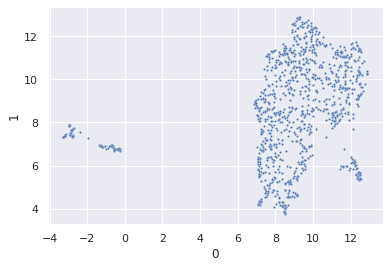

In [57]:
sns.scatterplot(data=original_embedding, x = 0, y=1, alpha=1, s=5)

In [58]:
embedding_beta = pd.DataFrame(reducer.transform(beta_df))
embedding_mmd = pd.DataFrame(reducer.transform(mmd_df))
embedding_vanilla = pd.DataFrame(reducer.transform(vanilla_df))

In [59]:
embedding_beta = pd.concat([embedding_beta, labels_beta], axis =1 ).rename(columns = {'label': ''})
embedding_mmd = pd.concat([embedding_mmd, labels_mmd], axis =1 ).rename(columns = {'label': ''})
embedding_vanilla = pd.concat([embedding_vanilla, labels_vanilla], axis =1 ).rename(columns = {'label': ''})

In [60]:
sns.set(font_scale=1)

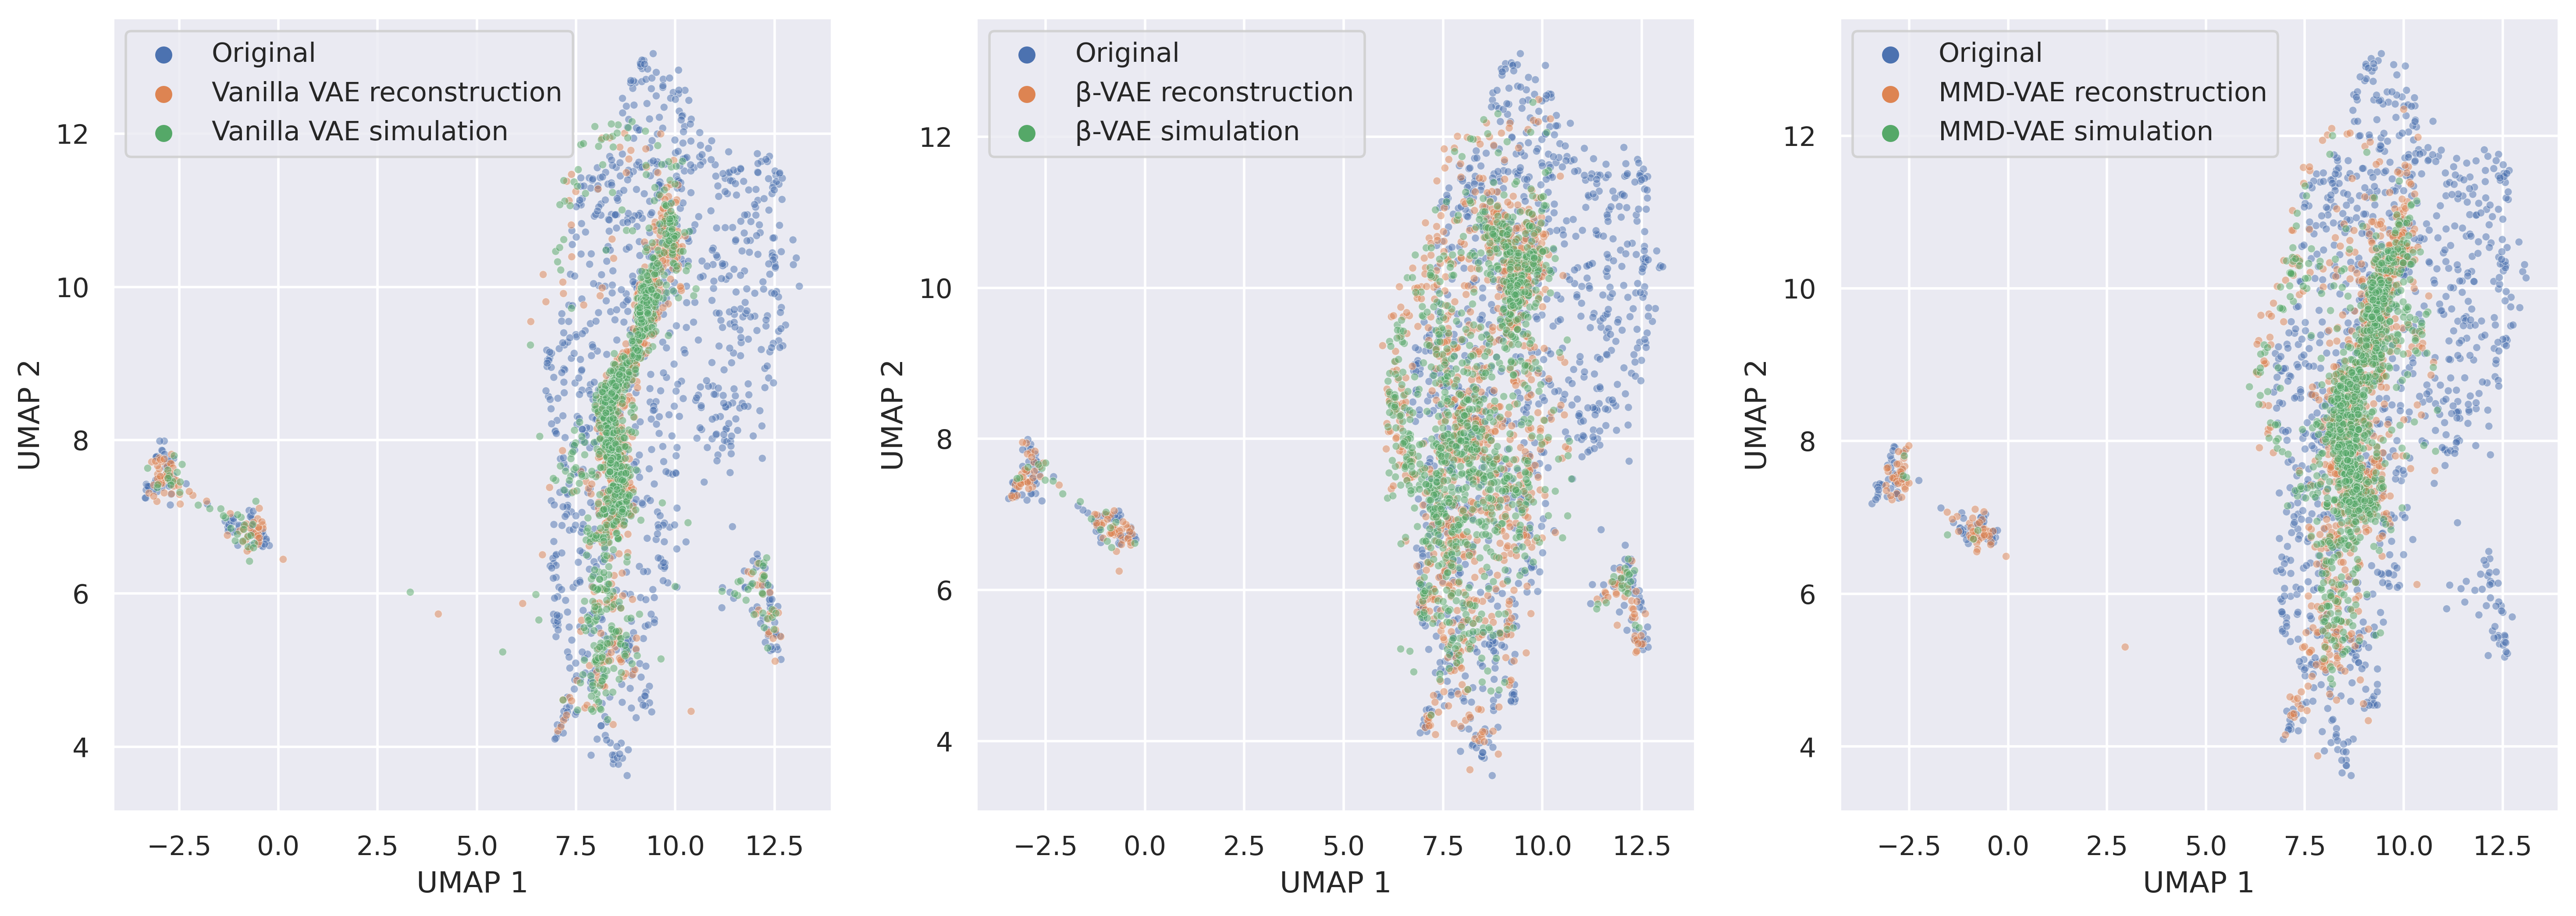

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6), dpi=400)
sns.scatterplot(data=embedding_vanilla, ax=ax1, x = 0, y=1, hue='', alpha=0.5, s=10
)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')

sns.scatterplot(data=embedding_beta, ax=ax2, x = 0, y=1, hue='', alpha=0.5, s=10
)
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

sns.scatterplot(data=embedding_mmd, ax=ax3, x = 0, y=1, hue='', alpha=0.5, s=10
)
ax3.set_xlabel('UMAP 1')
ax3.set_ylabel('UMAP 2')

plt.show()